### Домашнее задание

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix
import itertools
from pandas_profiling import ProfileReport

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [3]:
import shap
shap.initjs()

In [4]:
# https://www.kaggle.com/sagnik1511/car-insurance-data
df = pd.read_csv('Car_Insurance_Claim.csv')

In [5]:
df.head(5)

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

In [7]:
rename_dict = {'AGE':'Возраст', 'GENDER':'Пол','RACE':'Раса','DRIVING_EXPERIENCE': 'Водительский_опыт',
               'EDUCATION':'Образование', 'INCOME':'Доход', 'CREDIT_SCORE':'Кредитный_рейтинг', 
               'VEHICLE_OWNERSHIP': 'Владение_ТС', 'VEHICLE_YEAR':'Возраст_ТС', 'MARRIED':'Семейное_положение', 
               'CHILDREN': 'Дети', 'POSTAL_CODE':'Почтовый_код', 'ANNUAL_MILEAGE':'Ежегодный_пробег', 
               'VEHICLE_TYPE':'Вид_ТС', 'SPEEDING_VIOLATIONS': 'Рост_нарушений', 'DUIS':'Нетрезвый_за_рулём', 
               'PAST_ACCIDENTS':'Прошлые_инциденты'}
df.rename(columns=rename_dict, inplace=True)

Описание и обзорный анализ выбранного датасета произведём при помощи пакета __"pandas_profiling"__

In [8]:
ProfileReport(df, title="Pandas Profiling Report")

In [9]:
cat_OHE = ['Возраст','Образование','Доход', 'Почтовый_код' ]
cat_Label = ['Пол','Раса', 'Водительский_опыт','Возраст_ТС','Вид_ТС']
missing = ['Кредитный_рейтинг', 'Ежегодный_пробег']
remainder = ['Владение_ТС', 'Семейное_положение',  'Дети', 'Рост_нарушений', 'Нетрезвый_за_рулём', 'Прошлые_инциденты']

In [10]:
X, y = df.drop(['OUTCOME', 'ID'], 1), df['OUTCOME']

In [11]:
def OHE_feature_names(X, names):
    res = []
    for name in names:
        n = [name + '_' +str(i) for i in range(len(X[name].unique()))]
        res += n 
    return res

In [12]:
columns = missing + OHE_feature_names(X, cat_OHE) + cat_Label + remainder

In [13]:
transformer = ColumnTransformer([('missing', SimpleImputer(strategy ='median'), missing),
                                 ('category', OneHotEncoder(), cat_OHE),
                                 ('label', OrdinalEncoder(), cat_Label)],\
                         remainder ='passthrough')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
X_train = pd.DataFrame(transformer.fit_transform(X_train), columns = columns)

In [16]:
X_test = pd.DataFrame(transformer.fit_transform(X_test), columns = columns)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Кредитный_рейтинг   7000 non-null   float64
 1   Ежегодный_пробег    7000 non-null   float64
 2   Возраст_0           7000 non-null   float64
 3   Возраст_1           7000 non-null   float64
 4   Возраст_2           7000 non-null   float64
 5   Возраст_3           7000 non-null   float64
 6   Образование_0       7000 non-null   float64
 7   Образование_1       7000 non-null   float64
 8   Образование_2       7000 non-null   float64
 9   Доход_0             7000 non-null   float64
 10  Доход_1             7000 non-null   float64
 11  Доход_2             7000 non-null   float64
 12  Доход_3             7000 non-null   float64
 13  Почтовый_код_0      7000 non-null   float64
 14  Почтовый_код_1      7000 non-null   float64
 15  Почтовый_код_2      7000 non-null   float64
 16  Почтов

In [18]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [20]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

### Описание:
Позволяет понять вклад признаков для одного наблюдения (предсказания)
   - Вероятность того что данный человек обратиться в страховую = 0,23.
   - Вероятность обращения повышают такие характеристики как:
       - пол: женщина
       - машина ей не принадлежит
   - С другой стороны снижают риски:
       - опыт вождения
       - возраст ТС после 2015г. (новая машина)
       - проживает в районе где не обращаются в страховую
       - не большой пробег

In [21]:
# смотрим кодировку поля Пол
df['Пол'].value_counts(), X_train['Пол'].value_counts()

(female    5010
 male      4990
 Name: Пол, dtype: int64,
 1.0    3506
 0.0    3494
 Name: Пол, dtype: int64)

In [22]:
# смотрим кодировку
df['Владение_ТС'].value_counts(), X_train['Владение_ТС'].value_counts()

(1.0    6970
 0.0    3030
 Name: Владение_ТС, dtype: int64,
 1.0    4885
 0.0    2115
 Name: Владение_ТС, dtype: int64)

In [23]:
# смотрим кодировку
df['Возраст_ТС'].value_counts(), X_train['Возраст_ТС'].value_counts()

(before 2015    6967
 after 2015     3033
 Name: Возраст_ТС, dtype: int64,
 1.0    4884
 0.0    2116
 Name: Возраст_ТС, dtype: int64)

In [24]:
# смотрим кодировку
df['Водительский_опыт'].value_counts(), X_train['Водительский_опыт'].value_counts()

(0-9y      3530
 10-19y    3299
 20-29y    2119
 30y+      1052
 Name: Водительский_опыт, dtype: int64,
 0.0    2477
 1.0    2300
 2.0    1461
 3.0     762
 Name: Водительский_опыт, dtype: int64)

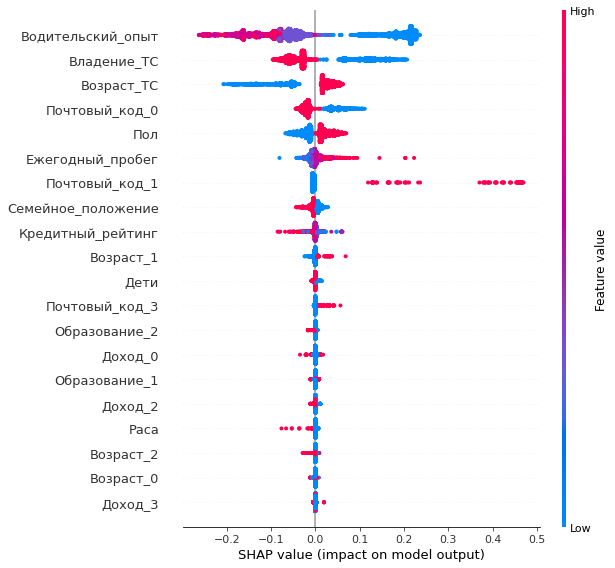

In [25]:
shap.summary_plot(shap_values, X_train)

### Описание:
Позволяет увидеть вклад признаков всей выборки
    
   - Исходя из графика можно сделать описательный вывод человека обращающего в страховую:
        - Это человек с малым опытом вождения, не владеющий ТС (ездиющий на чужой машине), на машине 
            до 2015 года выпуска, женщина, которая много проводит за рулём (большой ежегодный пробег)
            с определённым семейным положением = 0 (данные не дают с уверенность сказать какое имеено семейное положение)
    
        - Также имеется интересный факт что люди проживающие по разным почтовым адресам по разному себя ведут принимая решение обращаться в страховую или нет. (Разница в признаках Почтовый_код_0 и Почтовый_код_1)
            Это может быть следствием работы отделений страховой компании, что требуют уделить внимание. 



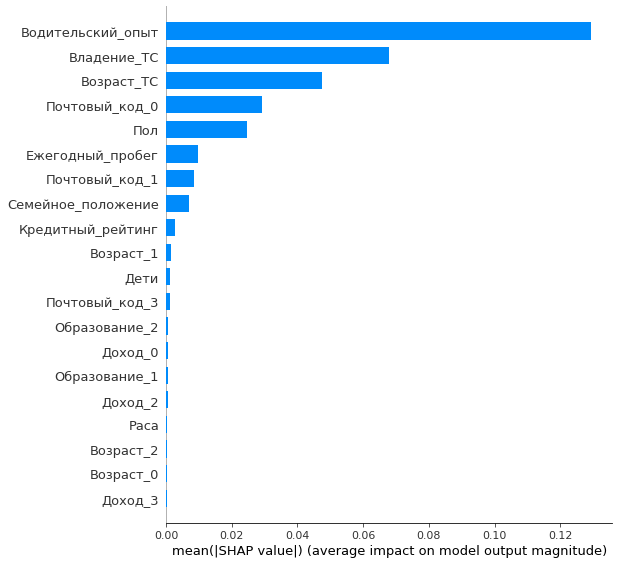

In [26]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Описание:
Показывает значение фичей влияющих на принятие решения. Чем выше фича тем она значимей.


In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
preds = model.predict(xgboost.DMatrix(X_test, label=y_test))

Confusion matrix, without normalization
[[1850  213]
 [ 230  707]]


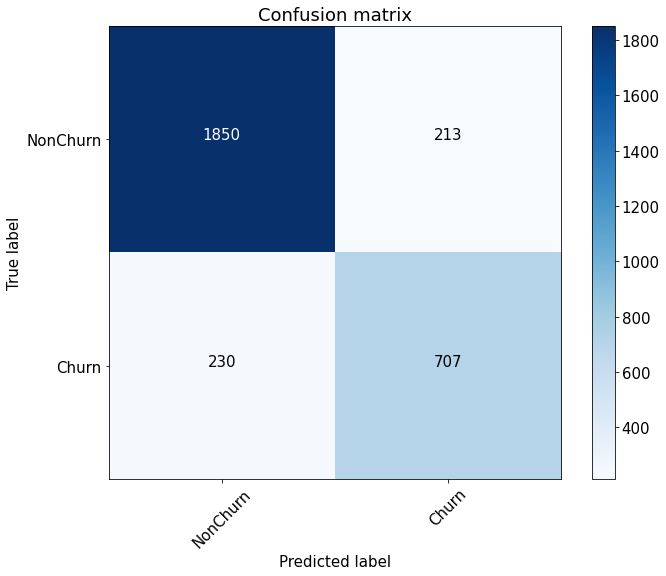

In [29]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>=0.5)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                     title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()